# **EXP3 Predicting Missing Cell-Types from Bulks using Deconvolution Residual**

*This file includes EXP3 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Data downloaded from: https://singlecell.broadinstitute.org/single_cell/study/SCP1376/a-single-cell-atlas-of-human-and-mouse-white-adipose-tissue#study-download

Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ 
PMID: 35296864

**Experimental Details:**
We leveraged the datasets with real missing cell types, incorporating realistic proportions and random proportions, adding realistic noise to the pseudbulks. The dataset encompassed both single-nucleus and single-cell experiments, with the single-cell data showing the absence of two cell types (adipocytes and mesothelium cells) compared to the single-nucleus. Pseudobulks created with realistic proportions, were generated using single-nucleus proportions containing all cell types, with variation introduced by adding Gaussian noise to the proportions. Random proportions were generated similarly to previous experiments using a random vector. We also included a new kind of pseudobulk with noise added to account for library size and random variability in bulks RNA-seq. 

References were constructed by sampling cells from the single-nucleus data, either using single-cell proportions (missing 2 cells) or with the single-nucleus proportions (missing 0 cells). This process was repeated for each of the three deconvolution methods, as described above.

The deconvolution steps were conducted for 1000 bulks for each set of random and realistic proportions, with and without added noise. Residuals were calculated as in previous experiments. Factors obtained from the factorization of residuals were then compared to the proportions of the two missing cell types from the single-nucleus data. Performance assessment was also conducted as stated above.

*This file can be run one kernel at a time, or all at once*

In [2]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from sklearn.utils import resample
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [13]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_adp_EXP3"
actual_path = os.getcwd()
path = f"{actual_path}/../data/EXP3/"
aug_data_path = f"{actual_path}/../data/EXP3/"
cibersort_path = f"{aug_data_path}/cibersort/"

#if you want pseudobulks to be made, change to True before running:
make_pseudos = False
prep_cibersort = False
random_seed = 88

## **Reading in all the data:**

In [5]:
#metadata containing cell types
cell_meta_name = f"{path}Hs.metadata.tsv"
cell_meta = pd.read_csv(cell_meta_name, sep='\t')
cell_meta

,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__custom,cell_subtype__custom,cell_type__ontology_id,cell_type__ontology_label
0,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,mesothelium,hMes1,CL:0000077,mesothelial cell
1,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,macrophage,hMac3,CL:0000235,macrophage
2,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,macrophage,hMac1,CL:0000235,macrophage
3,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,mesothelium,hMes3,CL:0000077,mesothelial cell
4,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,adipocyte,hAd2,CL:0000136,fat cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166144,Hs_SAT_SVF_249-2B-1_TTATATGGGATC,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,EPI249,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,6.137184,1554,883,-0.000273,0.012523,G2M,ASPC,hASPC2,CL:0002334,preadipocyte
166145,Hs_SAT_SVF_249-2B-1_TTATTGATCGCA,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,EPI249,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,9.544113,2272,1556,0.075652,-0.006552,S,ASPC,hASPC1,CL:0002334,preadipocyte
166146,Hs_SAT_SVF_249-2B-1_TTCTAGCCCGCA,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,EPI249,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,3.133744,1770,1002,-0.001814,-0.017952,G1,ASPC,hASPC1,CL:0002334,preadipocyte
166147,Hs_SAT_SVF_249-2B-1_TTGAACAGGTCT,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,EPI249,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,4.272864,1593,816,0.020562,-0.005713,S,macrophage,hMac1,CL:0000235,macrophage


In [6]:
#reading in both adatas containing count matrix
sn_adata = sc.read_10x_mtx(path, prefix = 'Hs10X.counts.', var_names='gene_symbols', make_unique=True)
sc_adata = sc.read_10x_mtx(path, prefix = 'HsDrop.counts.', var_names='gene_symbols', make_unique=True)
sc_adata

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].


AnnData object with n_obs × n_vars = 28465 × 29093
    var: 'gene_ids', 'feature_types'

Extracting single nucleus cells:

In [7]:
#extracting cell ids for meta
cell_ids_sn = cell_meta[cell_meta["library_preparation_protocol__ontology_label"] == "10x 3' v3 sequencing"]["cell_type__ontology_label"].values	
cell_ids_sn = vp.capitalize_first_letters(cell_ids_sn)
cell_ids_sn

['Mesothelial cell',
 'Macrophage',
 'Macrophage',
 'Mesothelial cell',
 'Fat cell',
 'Macrophage',
 'Fat cell',
 'T cell',
 'Mesothelial cell',
 'Macrophage',
 'Fat cell',
 'Mesothelial cell',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'Smooth muscle cell',
 'Mesothelial cell',
 'Macrophage',
 'Mesothelial cell',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Endothelial cell',
 'Endothelial cell of lymphatic vessel',
 'Macrophage',
 'Mesothelial cell',
 'Mesothelial cell',
 'Dendritic cell',
 'Mesothelial cell',
 'T cell',
 'Endothelial cell of lymphatic vessel',
 'Smooth muscle cell',
 'Macrophage',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'T cell',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'T cell',
 'Preadipocyte',
 'Mesothelial cell',
 'Preadipocyte',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Preadipocyte',
 'Mesothelial cell',
 'P

In [8]:
#getting common cells between meta and count matrix
common_cells = np.intersect1d([sn_adata.obs.index], [cell_meta["cell_id"].values])
common_cells= list(common_cells)
#num of cells total
len(common_cells)

137684

In [9]:
#make index the same to assign cell types
cell_meta.index = cell_meta["cell_id"]
cell_meta_sc = cell_meta.loc[common_cells]
sn_adata.var["gene_ids"] = sn_adata.var.index

And single cell:

In [10]:
#extracting cell ids for meta
cell_ids_sc = cell_meta[cell_meta["library_preparation_protocol__ontology_label"] == "Drop-seq"]["cell_type__ontology_label"].values	
cell_ids_sc = vp.capitalize_first_letters(cell_ids_sc)
cell_ids_sc

['Preadipocyte',
 'Monocyte',
 'Preadipocyte',
 'Dendritic cell',
 'Preadipocyte',
 'Dendritic cell',
 'Preadipocyte',
 'Preadipocyte',
 'Macrophage',
 'Monocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'T cell',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Neutrophil',
 'Preadipocyte',
 'Macrophage',
 'Immature nk t cell',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'Monocyte',
 'Preadipocyte',
 'Monocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Macrophage',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Immature nk t cell',
 'Preadipocyte',
 'Monocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Monocyte',
 'T cell',
 'Macrophage',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'Dendritic cell'

In [11]:
#getting common cells between meta and count matrix
common_cells = np.intersect1d([sc_adata.obs.index], [cell_meta["cell_id"].values])
common_cells= list(common_cells)
#num of cells total
len(common_cells)

28465

In [12]:
#make index the same to assign cell types
cell_meta.index = cell_meta["cell_id"]
cell_meta_sn = cell_meta.loc[common_cells]
sc_adata.var["gene_ids"] = sc_adata.var.index

## QC

QC of count matrix, rouhghly based on:

Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

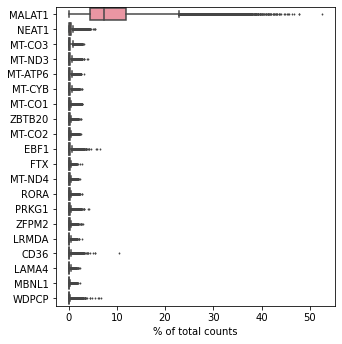

In [14]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

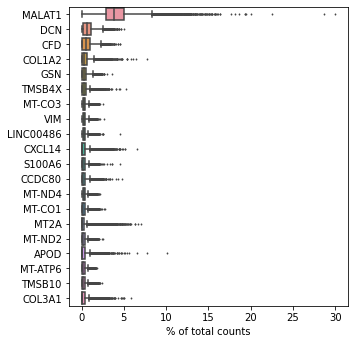

In [15]:
sc.pl.highest_expr_genes(sc_adata, n_top=20, )

In [16]:
#filtering genes and cells 
sc.pp.filter_cells(sn_adata, min_genes=300)
sc.pp.filter_genes(sn_adata, min_cells=7)
#filtering genes and cells 
sc.pp.filter_cells(sc_adata, min_genes=300)
sc.pp.filter_genes(sc_adata, min_cells=7)

In [17]:
#Not normalized
print(sn_adata.X.max())
print(sc_adata.X.max())

16528.0
2430.0


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


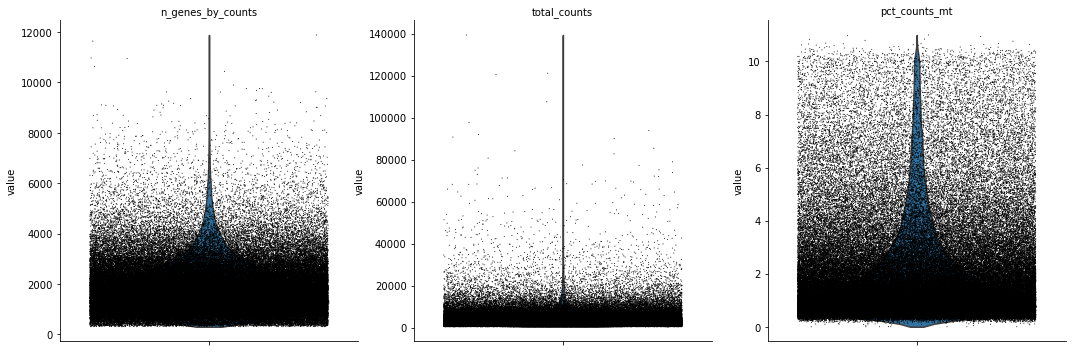

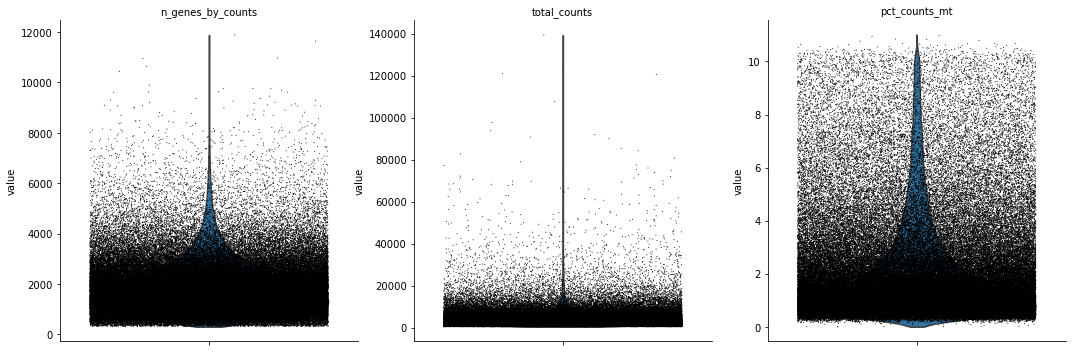

In [18]:
# remove genes with high mitochondrial content
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# remove genes with high mitochondrial content
sc_adata.var['mt'] = sc_adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

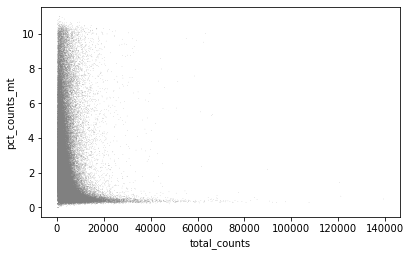

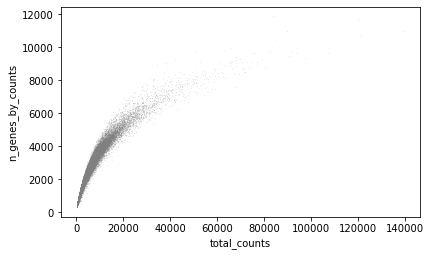

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


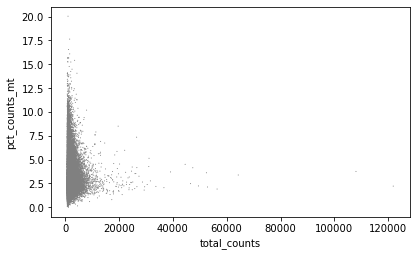

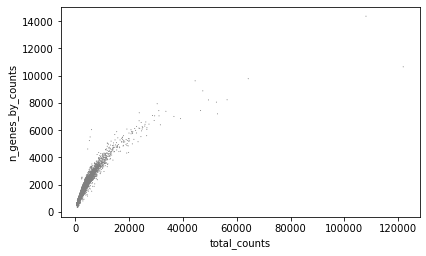

In [19]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sc_adata, x='total_counts', y='n_genes_by_counts')

In [20]:
sn_adata = sn_adata[sn_adata.obs.n_genes_by_counts < 6000, :]
sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 4, :]

sc_adata = sc_adata[sc_adata.obs.n_genes_by_counts < 6000, :]
sc_adata = sc_adata[sc_adata.obs.pct_counts_mt < 4, :]

In [21]:
#making copy to keep unnormalized for export
sn_adata_copy = sn_adata.copy()
sc_adata_copy = sc_adata.copy()

In [22]:
# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
#logging local adata
sc.pp.log1p(sn_adata)

# normalize to 10K counts per cell
sc.pp.normalize_total(sc_adata, target_sum=1e4)
#logging local adata
sc.pp.log1p(sc_adata)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


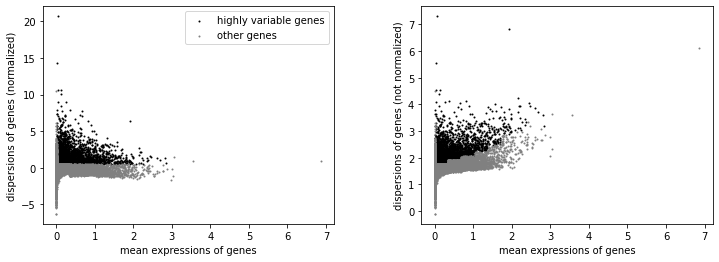

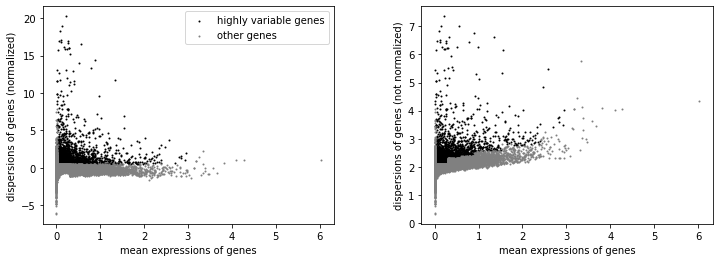

In [23]:
highly_var_genes = sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sn_adata)

highly_var_genes = sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sc_adata)

In [24]:
sc_adata

AnnData object with n_obs × n_vars = 18552 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## **Assigning cell types:**

In [25]:
# Merge the two DataFrames based on the indexes from before
merged_df_sn = pd.merge(sn_adata.obs, cell_meta, left_index=True, right_index=True)
merged_df_sn

,n_genes_x,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__custom,cell_subtype__custom,cell_type__ontology_id,cell_type__ontology_label
Hs_OAT_12-1_AAACCCAAGCTCGTGC,1023,1023,1309.0,19.0,1.451490,Hs_OAT_12-1_AAACCCAAGCTCGTGC,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.069519,1681,1023,-0.026009,-0.015240,G1,mesothelium,hMes1,CL:0000077,mesothelial cell
Hs_OAT_12-1_AAACCCAAGTTCGCAT,1666,1666,3549.0,42.0,1.183432,Hs_OAT_12-1_AAACCCAAGTTCGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.309946,2692,1666,-0.011481,-0.013545,G1,adipocyte,hAd2,CL:0000136,fat cell
Hs_OAT_12-1_AAACCCACAAGCAGGT,3639,3639,10669.0,400.0,3.749180,Hs_OAT_12-1_AAACCCACAAGCAGGT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.215578,2280,1270,-0.000967,0.002635,G2M,adipocyte,hAd2,CL:0000136,fat cell
Hs_OAT_12-1_AAACCCACAAGGGCAT,1805,1805,2822.0,37.0,1.311127,Hs_OAT_12-1_AAACCCACAAGGGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.602410,2670,1805,0.022549,-0.014975,S,mesothelium,hMes2,CL:0000077,mesothelial cell
Hs_OAT_12-1_AAACCCACACCCTGAG,2326,2326,4766.0,31.0,0.650441,Hs_OAT_12-1_AAACCCACACCCTGAG,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.314729,2989,2060,-0.020035,-0.006758,G1,adipocyte,hAd2,CL:0000136,fat cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_11-1_TTTGGAGGTTGCTCAA,1769,1769,2978.0,74.0,2.484889,Hs_SAT_11-1_TTTGGAGGTTGCTCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,3.626595,2951,1769,-0.047193,-0.023121,G1,nk_cell,hNK,CL:0000914,immature NK T cell
Hs_SAT_11-1_TTTGGAGTCTCCGATC,1813,1813,3184.0,58.0,1.821608,Hs_SAT_11-1_TTTGGAGTCTCCGATC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.251256,3066,1811,0.008630,0.010638,G2M,ASPC,hASPC5,CL:0002334,preadipocyte
Hs_SAT_11-1_TTTGGTTAGTGATGGC,4520,4520,17086.0,50.0,0.292637,Hs_SAT_11-1_TTTGGTTAGTGATGGC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.163877,2913,1778,-0.006596,-0.022388,G1,adipocyte,hAd4,CL:0000136,fat cell
Hs_SAT_11-1_TTTGGTTTCATGCCAA,1171,1171,1758.0,39.0,2.218430,Hs_SAT_11-1_TTTGGTTTCATGCCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.000000,2255,1171,0.001052,-0.011141,S,adipocyte,hAd2,CL:0000136,fat cell


In [26]:
# Merge the two DataFrames based on the indexes from before
merged_df_sc = pd.merge(sc_adata.obs, cell_meta, left_index=True, right_index=True)
merged_df_sc

,n_genes_x,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__custom,cell_subtype__custom,cell_type__ontology_id,cell_type__ontology_label
Hs_SAT_SVF_235-1A-1_CAAAGGATTGCG,1780,1780,4311.0,147.0,3.409882,Hs_SAT_SVF_235-1A-1_CAAAGGATTGCG,Hs_SAT_SVF_235-1A-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,9.160482,2289,1369,-0.027356,0.028213,G2M,dendritic_cell,hcDC2,CL:0000451,dendritic cell
Hs_SAT_SVF_235-1A-1_GAAGACCACAGA,1039,1039,1602.0,21.0,1.310861,Hs_SAT_SVF_235-1A-1_GAAGACCACAGA,Hs_SAT_SVF_235-1A-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,2.245789,1636,1039,-0.025165,-0.010202,G1,monocyte,hMono1,CL:0000576,monocyte
Hs_SAT_SVF_235-1A-1_AAATGGAGTTAC,1990,1990,3983.0,78.0,1.958323,Hs_SAT_SVF_235-1A-1_AAATGGAGTTAC,Hs_SAT_SVF_235-1A-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,1.882530,2465,1750,0.036697,0.016056,S,ASPC,hASPC2,CL:0002334,preadipocyte
Hs_SAT_SVF_235-1A-1_CATTCCCCATTA,827,827,1630.0,8.0,0.490798,Hs_SAT_SVF_235-1A-1_CATTCCCCATTA,Hs_SAT_SVF_235-1A-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,0.797546,1672,827,-0.025103,-0.022682,G1,LEC,hLEC1,CL:0002138,endothelial cell of lymphatic vessel
Hs_SAT_SVF_235-1A-1_TGTCAAAAAGAT,1607,1607,2687.0,54.0,2.009676,Hs_SAT_SVF_235-1A-1_TGTCAAAAAGAT,Hs_SAT_SVF_235-1A-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,2.791217,2256,1606,-0.001447,0.002162,G2M,ASPC,hASPC1,CL:0002334,preadipocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_SVF_249-2B-1_AATAGTTTGCAN,771,771,1166.0,32.0,2.744426,Hs_SAT_SVF_249-2B-1_AATAGTTTGCAN,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,7.461407,1471,742,-0.003471,0.003846,G2M,nk_cell,hNK,CL:0000914,immature NK T cell
Hs_SAT_SVF_249-2B-1_TCGACATAAAGC,807,807,1262.0,24.0,1.901743,Hs_SAT_SVF_249-2B-1_TCGACATAAAGC,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,7.686212,1532,785,0.019630,0.022777,G2M,t_cell,hTcell1,CL:0000084,T cell
Hs_SAT_SVF_249-2B-1_AGACACCAGCTN,672,672,988.0,23.0,2.327935,Hs_SAT_SVF_249-2B-1_AGACACCAGCTN,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,7.186235,1649,672,0.062419,-0.015406,S,ASPC,hASPC1,CL:0002334,preadipocyte
Hs_SAT_SVF_249-2B-1_CTCTGAACTGAT,1171,1171,2187.0,39.0,1.783265,Hs_SAT_SVF_249-2B-1_CTCTGAACTGAT,Hs_SAT_SVF_249-2B-1,PrimaryBioSample_Tissue,EFO:0008722,Drop-seq,...,5.669867,2075,1142,0.074252,0.005077,S,ASPC,hASPC1,CL:0002334,preadipocyte


In [27]:
# Extract the cell type labels from the merged DataFrame
cell_type_labels_sn = vp.capitalize_first_letters(merged_df_sn["cell_type__ontology_label"])

# Assign the cell type labels to the adata.obs DataFrame
sn_adata.obs["cell_types"] = cell_type_labels_sn
sn_adata_copy.obs["cell_types"] = cell_type_labels_sn
sn_adata_copy.var["highly_var_genes"] = sn_adata.var["highly_variable"]

In [28]:
# Extract the cell type labels from the merged DataFrame
cell_type_labels_sc = vp.capitalize_first_letters(merged_df_sc["cell_type__ontology_label"])

# Assign the cell type labels to the adata.obs DataFrame
sc_adata.obs["cell_types"] = cell_type_labels_sc
sc_adata_copy.obs["cell_types"] = cell_type_labels_sc
sc_adata_copy.var["highly_var_genes"] = sc_adata.var["highly_variable"]

In [29]:
#these are not normalized, used for pseudos
print(sn_adata_copy.X.max())
print(sc_adata_copy.X.max())

9832.0
1558.0


In [30]:
#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy.write_h5ad(adata_path)

#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata_copy.write_h5ad(adata_path)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


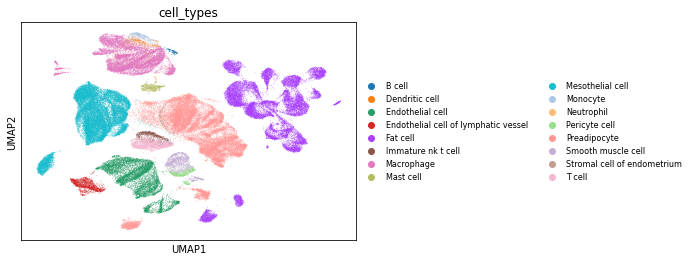

In [31]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color='cell_types', legend_fontsize=8)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


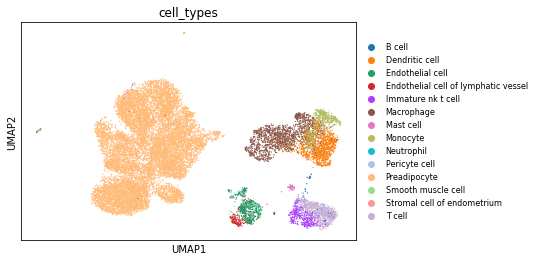

In [32]:
# calculate neighborhood graph
sc.pp.neighbors(sc_adata)

# make umap
sc.tl.umap(sc_adata)

# plot some markers of the RAW data
sc.pl.umap(sc_adata, color='cell_types', legend_fontsize=8)

Interesection File:

In [33]:
# write out the gene ids in intersection file
genes_all = np.intersect1d(sn_adata.var["gene_ids"], sc_adata.var["gene_ids"])
gene_out_file = os.path.join(aug_data_path, f"{res_name}_intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

## Cell type assignment QC:

In [34]:
adata_path = os.path.join(aug_data_path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
Counter(sn_adata.obs.cell_types)

Counter({'Mesothelial cell': 26276,
         'Fat cell': 24825,
         'Macrophage': 13625,
         'Preadipocyte': 26941,
         'Endothelial cell': 11480,
         'Endothelial cell of lymphatic vessel': 2339,
         'Pericyte cell': 1165,
         'T cell': 3022,
         'Smooth muscle cell': 2457,
         'B cell': 231,
         'Dendritic cell': 679,
         'Mast cell': 883,
         'Monocyte': 709,
         'Stromal cell of endometrium': 284,
         'Immature nk t cell': 1073,
         'Neutrophil': 77})

In [35]:
adata_path = os.path.join(aug_data_path, f"{res_name}_scadata_notlog.h5ad")
print(adata_path)
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
Counter(sc_adata.obs.cell_types)

/Users/ivicha/Documents/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_scadata_notlog.h5ad


Counter({'Dendritic cell': 983,
         'Monocyte': 636,
         'Preadipocyte': 13461,
         'Endothelial cell of lymphatic vessel': 157,
         'Macrophage': 1410,
         'T cell': 807,
         'Endothelial cell': 542,
         'Immature nk t cell': 389,
         'B cell': 36,
         'Neutrophil': 2,
         'Smooth muscle cell': 22,
         'Pericyte cell': 52,
         'Stromal cell of endometrium': 2,
         'Mast cell': 53})

Visualizing proportions:

In [36]:
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,Mesothelial cell,26276,0.226388
1,Fat cell,24825,0.213887
2,Macrophage,13625,0.117390
3,Preadipocyte,26941,0.232118
4,Endothelial cell,11480,0.098909
5,Endothelial cell of lymphatic vessel,2339,0.020152
6,Pericyte cell,1165,0.010037
7,T cell,3022,0.026037
8,Smooth muscle cell,2457,0.021169
9,B cell,231,0.001990


In [37]:
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,Dendritic cell,983,0.052986
1,Monocyte,636,0.034282
2,Preadipocyte,13461,0.725582
3,Endothelial cell of lymphatic vessel,157,0.008463
4,Macrophage,1410,0.076003
5,T cell,807,0.043499
6,Endothelial cell,542,0.029215
7,Immature nk t cell,389,0.020968
8,B cell,36,0.001940
9,Neutrophil,2,0.000108


## Removing cells that are not frequent:

In [38]:
#deleting cells that are less than 75 in each data type for accurate reference comparison:
nonfreq_cells_sc = sc_prop["Cell_Types"][sc_prop["Num_Cells"].values < 50] 
nonfreq_cells_sn = sn_prop["Cell_Types"][sn_prop["Num_Cells"].values < 50] 

#convert arrays to sets and perform the union operation
combined_set = set(nonfreq_cells_sc).union(set(nonfreq_cells_sn))

#convert the result back to a list if needed
nonfreq_cells = list(combined_set)
print(nonfreq_cells)

['Neutrophil', 'B cell', 'Stromal cell of endometrium', 'Smooth muscle cell']


In [39]:
# Filter observations based on the condition for sn_adata
sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(nonfreq_cells)]

# Filter observations based on the condition for sc_adata
sc_adata = sc_adata[~sc_adata.obs["cell_types"].isin(nonfreq_cells)]

In [40]:
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
8,Dendritic cell,679,0.006008
4,Endothelial cell,11480,0.101578
5,Endothelial cell of lymphatic vessel,2339,0.020696
1,Fat cell,24825,0.219657
11,Immature nk t cell,1073,0.009494
2,Macrophage,13625,0.120557
9,Mast cell,883,0.007813
0,Mesothelial cell,26276,0.232496
10,Monocyte,709,0.006273
6,Pericyte cell,1165,0.010308


In [41]:
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
0,Dendritic cell,983,0.053164
6,Endothelial cell,542,0.029313
3,Endothelial cell of lymphatic vessel,157,0.008491
7,Immature nk t cell,389,0.021038
4,Macrophage,1410,0.076257
9,Mast cell,53,0.002866
1,Monocyte,636,0.034397
8,Pericyte cell,52,0.002812
2,Preadipocyte,13461,0.728015
5,T cell,807,0.043645


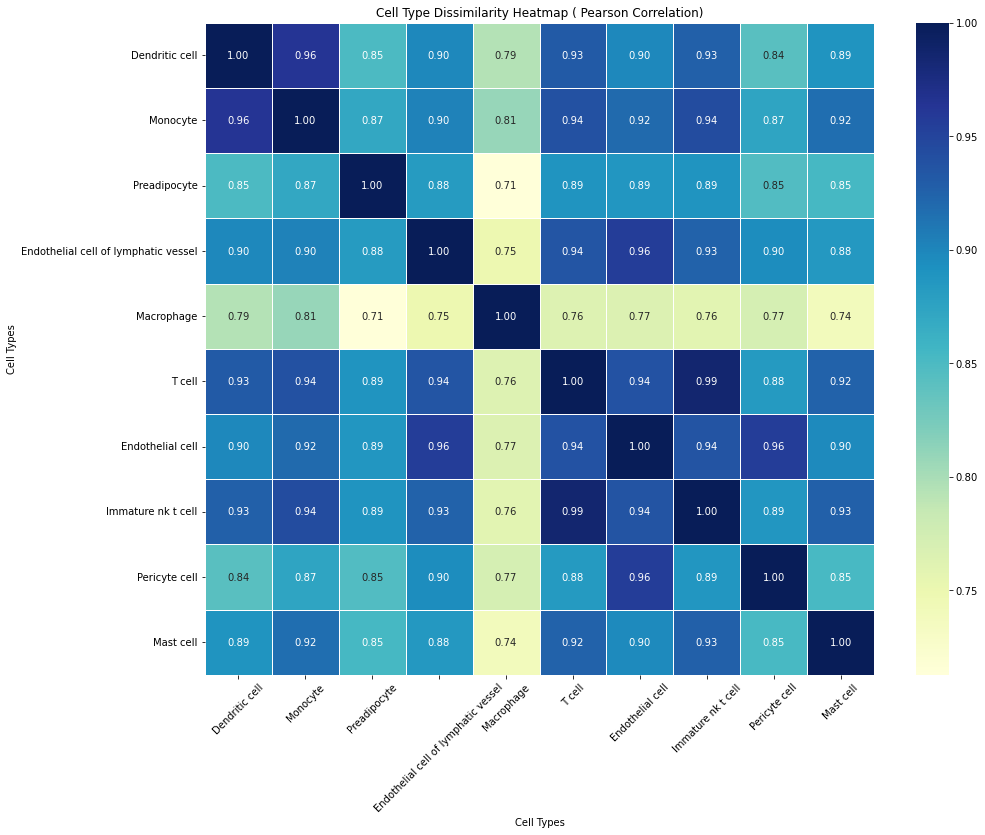

In [42]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

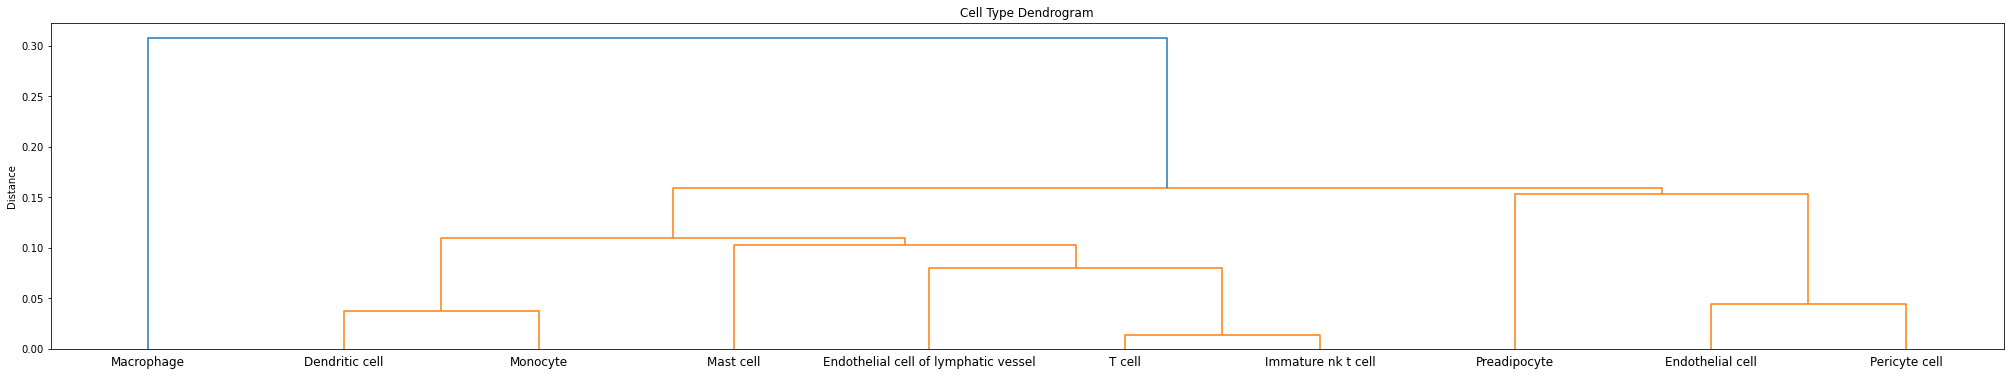

In [43]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

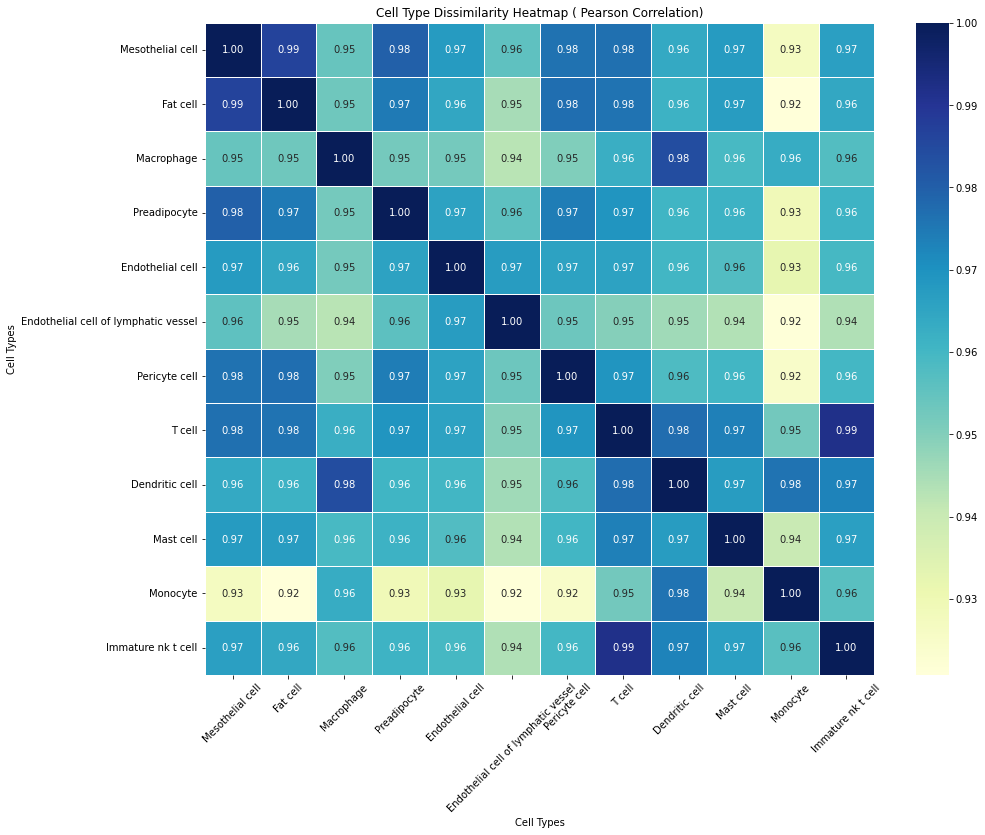

In [44]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without snaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

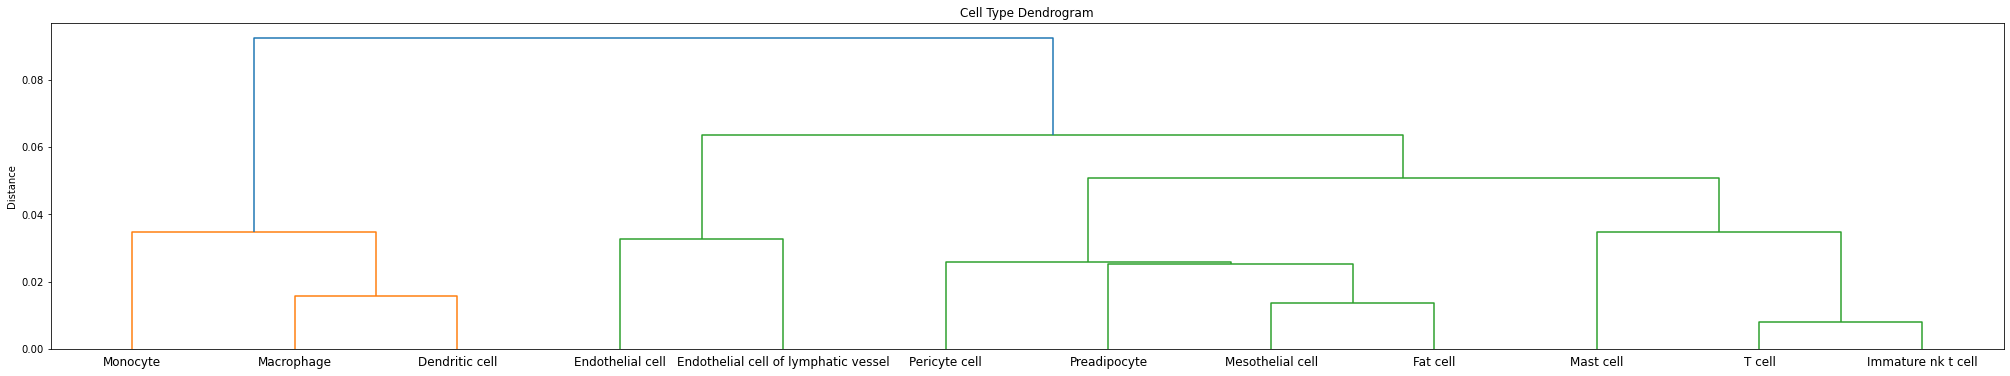

In [45]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

Writing in both

In [46]:
#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata.write_h5ad(adata_path)

#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata.write_h5ad(adata_path)

## Pseudobulks Creation

And Pseudobulk-creating loops:
1. All Cell Types, Noise added
2. All Cell Types, No noise added

Run all or one at a time as needed.

In [47]:
print(sn_adata.X.max())
print(sc_adata.X.max())

9832.0
1558.0


**Running Pseudobulk-Creating Loops**

In [48]:
adata_path = os.path.join(aug_data_path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
Counter(sn_adata.obs.cell_types)

# no specific cell noise
len_vector = sn_adata.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata.obs.cell_types.unique()
num_random = 200 #number of random pseudos

#adding cell types to both
sn_adata.obs['scpred_CellType'] = sn_adata.obs["cell_types"] #to match var name in functions
sn_adata_copy.obs['scpred_CellType'] = sn_adata.obs["cell_types"]

#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

,Mesothelial cell,Fat cell,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
0,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333


All Cell Types, No Noise:

In [49]:
#not normalized
print(sn_adata.X.max())

9832.0


In [50]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
sample_noise = None
noise_type = "No noise"
if make_pseudos:  
        for idx in range(0,10):
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the real cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type=noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type= noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

All Cell Types, Noise:

In [51]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
noise_type = "No sample noise"
sample_noise = None
if make_pseudos:  
        for idx in range(0,10):
                print(f"**idx {idx}**")
                sample_noise = None
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the real cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type=noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_noise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_noise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

QC Pseudobulks Made:

In [52]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1200

In [53]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= "noise_", 
                        file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_75036/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


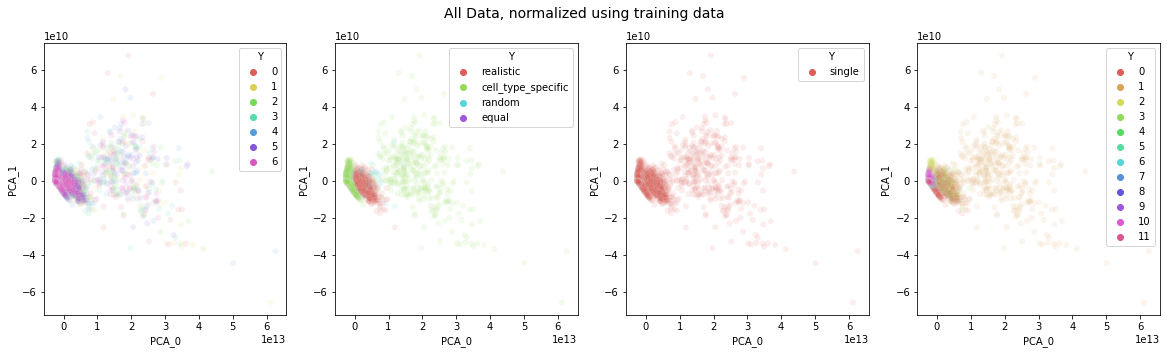

In [54]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.103s...
[t-SNE] Computed neighbors for 8000 samples in 14.639s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 4989607420.828942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.217987
[t-SNE] KL divergence after 500 iterations: 0.661868
(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_75036/2289032286.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


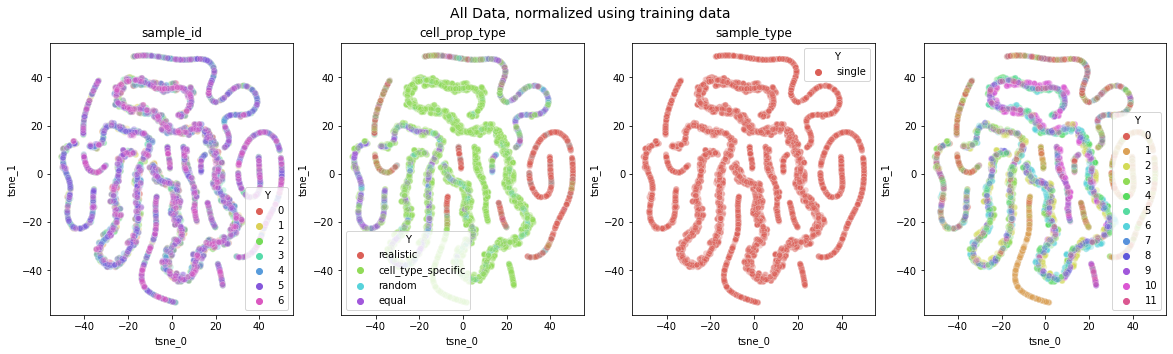

In [55]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [56]:
#cut to only the sample specified above
idx_interest = np.where(meta_df.cell_prop_type == "random")[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,7461.805286,25948.674553,0.000000,8.890777e+06,14166.152696,1030.329957,234930.552788,189.430446,25951.794372,11.140674,...,0.000000,0.0,0.0,1.749701,0.000000,10.383708,0.000000,0.000000,17.035064,0.0
1,5861.055393,24708.584947,238.642930,1.591422e+07,68134.988568,2546.577363,112042.562209,69.612441,38293.716281,0.000000,...,0.000000,0.0,0.0,8.397268,14.653988,0.000000,0.000000,25.292799,0.000000,0.0
2,3712.749530,19005.038761,121.424371,2.434035e+07,109600.838824,776.464770,221429.396367,141.537689,16084.746064,0.000000,...,11.216337,0.0,0.0,0.000000,0.000000,0.947887,0.000000,0.880017,1.898407,0.0
3,3107.503426,27811.703889,42.821562,1.749195e+07,31509.332831,1083.609884,320486.357829,83.075403,26080.288015,10.805828,...,0.000000,0.0,0.0,0.000000,0.000000,0.961814,0.000000,14.429726,0.983119,0.0
4,1245.657901,15239.028249,136.730070,2.131466e+07,41950.981472,4376.261391,521932.492048,259.212350,47979.849878,13.653098,...,12.772177,0.0,0.0,10.397034,0.812672,0.000000,0.897724,1.094033,3.773295,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2966.096530,17833.781274,81.959552,2.707667e+07,78017.494320,571.585154,435325.885256,169.777063,47711.964705,28.962179,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.101477,0.000000,1.875032,0.0
1996,3290.782820,28497.173370,598.700021,9.228119e+06,25944.403541,2444.026594,264205.931613,484.279649,31462.140962,9.355784,...,0.000000,0.0,0.0,22.900671,21.687877,0.000000,1.940045,6.236421,7.888807,0.0
1997,4811.440274,21931.083973,41.348010,1.860945e+07,32747.550357,1545.734459,97698.068172,78.546733,34847.167638,11.723017,...,10.940908,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.883623,0.0
1998,2959.132568,12436.124893,112.748426,1.738438e+07,56751.334648,2938.847603,307607.531834,95.246089,17028.719458,1.088620,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.915963,0.000000,0.0


In [57]:
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,7461.805286,25948.674553,0.000000,8.890777e+06,14166.152696,1030.329957,234930.552788,189.430446,25951.794372,11.140674,...,0.000000,0.0,0.0,1.749701,0.000000,10.383708,0.000000,0.000000,17.035064,0.0
1,5861.055393,24708.584947,238.642930,1.591422e+07,68134.988568,2546.577363,112042.562209,69.612441,38293.716281,0.000000,...,0.000000,0.0,0.0,8.397268,14.653988,0.000000,0.000000,25.292799,0.000000,0.0
2,3712.749530,19005.038761,121.424371,2.434035e+07,109600.838824,776.464770,221429.396367,141.537689,16084.746064,0.000000,...,11.216337,0.0,0.0,0.000000,0.000000,0.947887,0.000000,0.880017,1.898407,0.0
3,3107.503426,27811.703889,42.821562,1.749195e+07,31509.332831,1083.609884,320486.357829,83.075403,26080.288015,10.805828,...,0.000000,0.0,0.0,0.000000,0.000000,0.961814,0.000000,14.429726,0.983119,0.0
4,1245.657901,15239.028249,136.730070,2.131466e+07,41950.981472,4376.261391,521932.492048,259.212350,47979.849878,13.653098,...,12.772177,0.0,0.0,10.397034,0.812672,0.000000,0.897724,1.094033,3.773295,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2966.096530,17833.781274,81.959552,2.707667e+07,78017.494320,571.585154,435325.885256,169.777063,47711.964705,28.962179,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.101477,0.000000,1.875032,0.0
1996,3290.782820,28497.173370,598.700021,9.228119e+06,25944.403541,2444.026594,264205.931613,484.279649,31462.140962,9.355784,...,0.000000,0.0,0.0,22.900671,21.687877,0.000000,1.940045,6.236421,7.888807,0.0
1997,4811.440274,21931.083973,41.348010,1.860945e+07,32747.550357,1545.734459,97698.068172,78.546733,34847.167638,11.723017,...,10.940908,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.883623,0.0
1998,2959.132568,12436.124893,112.748426,1.738438e+07,56751.334648,2938.847603,307607.531834,95.246089,17028.719458,1.088620,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.915963,0.000000,0.0


In [58]:
#adding gene ids as columns
pseudos_df.columns = sn_adata.var_names
pseudos_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,7461.805286,25948.674553,0.000000,8.890777e+06,14166.152696,1030.329957,234930.552788,189.430446,25951.794372,11.140674,...,0.000000,0.0,0.0,1.749701,0.000000,10.383708,0.000000,0.000000,17.035064,0.0
1,5861.055393,24708.584947,238.642930,1.591422e+07,68134.988568,2546.577363,112042.562209,69.612441,38293.716281,0.000000,...,0.000000,0.0,0.0,8.397268,14.653988,0.000000,0.000000,25.292799,0.000000,0.0
2,3712.749530,19005.038761,121.424371,2.434035e+07,109600.838824,776.464770,221429.396367,141.537689,16084.746064,0.000000,...,11.216337,0.0,0.0,0.000000,0.000000,0.947887,0.000000,0.880017,1.898407,0.0
3,3107.503426,27811.703889,42.821562,1.749195e+07,31509.332831,1083.609884,320486.357829,83.075403,26080.288015,10.805828,...,0.000000,0.0,0.0,0.000000,0.000000,0.961814,0.000000,14.429726,0.983119,0.0
4,1245.657901,15239.028249,136.730070,2.131466e+07,41950.981472,4376.261391,521932.492048,259.212350,47979.849878,13.653098,...,12.772177,0.0,0.0,10.397034,0.812672,0.000000,0.897724,1.094033,3.773295,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2966.096530,17833.781274,81.959552,2.707667e+07,78017.494320,571.585154,435325.885256,169.777063,47711.964705,28.962179,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.101477,0.000000,1.875032,0.0
1996,3290.782820,28497.173370,598.700021,9.228119e+06,25944.403541,2444.026594,264205.931613,484.279649,31462.140962,9.355784,...,0.000000,0.0,0.0,22.900671,21.687877,0.000000,1.940045,6.236421,7.888807,0.0
1997,4811.440274,21931.083973,41.348010,1.860945e+07,32747.550357,1545.734459,97698.068172,78.546733,34847.167638,11.723017,...,10.940908,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.883623,0.0
1998,2959.132568,12436.124893,112.748426,1.738438e+07,56751.334648,2938.847603,307607.531834,95.246089,17028.719458,1.088620,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.915963,0.000000,0.0


In [59]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,2692.052119,29527.470261,226.356551,1.718726e+07,39184.711475,1353.528856,441244.953644,198.207822,43141.003876,85.550136,...,1.138475,0.946797,0.00000,1.099441,1.805488,4.990441,0.0,11.830828,1.184223,0.000000
929,947.243523,10709.530174,67.120813,2.880636e+07,40000.965522,1797.631133,442122.465092,250.322922,93344.399701,34.869625,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1506,2925.775335,31068.810043,60.145630,3.767561e+07,254688.832112,1751.667574,149649.288823,26.119288,24559.794868,22.017268,...,0.000000,0.000000,0.00000,1.119451,4.159404,0.000000,0.0,0.000000,0.000000,0.000000
237,658.052470,3737.591290,49.125976,2.387174e+07,25146.847220,544.884041,303774.155698,75.095603,158413.369486,2.614979,...,2.002560,0.000000,0.00000,0.968811,0.000000,0.000000,0.0,0.000000,0.000000,0.917045
1371,3278.908222,29575.294229,83.816090,1.512915e+07,40333.300982,1664.715506,301373.340200,73.501421,26407.294469,4.566142,...,1.875735,0.000000,0.00000,1.003475,0.000000,0.000000,0.0,17.302756,6.090182,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,3104.637201,21380.736438,154.852799,1.307471e+07,77808.947239,2410.022569,332713.120567,124.421112,14005.430588,11.309236,...,4.842599,0.000000,0.00000,2.724280,0.000000,0.000000,0.0,0.000000,1.641018,0.000000
1132,3368.419012,40910.240171,182.648756,1.377186e+07,52083.874799,1658.402379,131877.032300,363.902210,53193.560327,3.787443,...,1.009819,0.000000,0.00000,10.484237,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1998,2959.132568,12436.124893,112.748426,1.738438e+07,56751.334648,2938.847603,307607.531834,95.246089,17028.719458,1.088620,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.915963,0.000000,0.000000
1988,7045.654768,36119.889787,103.841846,1.319846e+07,235557.220615,779.568078,180767.261212,209.197489,18196.212362,5.686965,...,0.000000,0.000000,1.11409,10.420713,0.000000,0.000000,0.0,0.000000,1.932226,0.000000


## **CibersortX Preparation**

Must have cibersort_prep = True in parameters.

Deleting cells in large cell types to be able to run CibersortX:
(data is too large)

In [60]:
if prep_cibersort:
    #define the cell types to limit and the desired maximum number of cells
    cell_types_to_limit = ["preadipocyte", "mesothelial cell", "fat cell", "macrophage", "pericyte", 
                                "endothelial cell", "pericyte cell", "endothelial cell of lymphatic vessel", 
                                "T cell", "smooth muscle cell", "immature NK T cell"]
    max_cells_per_type = 1000

    #dreate a mask to identify cells from the cell types to limit
    mask_to_limit = sn_adata_copy.obs["cell_types"].isin(cell_types_to_limit)

    #create a mask for the remaining cell types
    mask_remaining = ~mask_to_limit

    #initialize a dictionary to keep track of removed cells per cell type
    removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

    #initialize arrays to store new observations and filtered indices
    new_obs = []
    filtered_indices = []

    #iterate through each cell in the original sn_adata object
    for cell_idx, cell_type in enumerate(sn_adata_copy.obs["cell_types"]):
        if cell_type in cell_types_to_limit:
            removed_count = removed_cells_count.get(cell_type, 0)
            if removed_count < max_cells_per_type:
                removed_cells_count[cell_type] = removed_count + 1
                filtered_indices.append(cell_idx)

    #create a new AnnData object with the filtered cells
    filtered_sn_adata = sc.AnnData(
        X=sn_adata_copy.X[filtered_indices],
        obs=sn_adata_copy.obs.iloc[filtered_indices],
        var=sn_adata_copy.var
    )

    #cppend the remaining cell types to the filtered sn_adata object
    filtered_sn_adata = filtered_sn_adata.concatenate(
        sn_adata_copy[mask_remaining],
        join="outer"
    )
    #QC
    Counter(filtered_sn_adata.obs.cell_types)

In [61]:
if prep_cibersort:
    dense_matrix = filtered_sn_adata.X.todense()

    dense_df = pd.DataFrame(dense_matrix, columns = filtered_sn_adata.var['gene_ids'])
    dense_df.insert(loc=0, column='cell_types', value=filtered_sn_adata.obs["cell_types"].to_list())
    #qc
    sig_df_sn = dense_df
    print(sig_df_sn.shape)

In [62]:
if prep_cibersort:
    #details
    exp_id = f"{res_name}"
    patient_idx = f"{noise_type}"
    #and create files for CIBERSORTX
    mix, sig = sn_sc_preprocess.write_cs_bp_files(aug_data_path, out_file_id = exp_id, 
                                            sig_df = sig_df_sn,  X_train = pseudos_df, patient_idx=patient_idx)
    sig